# Import libraries

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':'tight'}
plt.rcParams["figure.figsize"] = [15, 8]
import numpy as np
from numpy.random import uniform, seed
import pandas as pd
from time import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# 1. (40 pts) Define functions
### Define the following functions

In [2]:
def one_hot_encode(labels):
    """
        Turn single digit numerical value classes into length 10 vectors...
        1 for the positive class and 0's for the other 9 negative classes.
    """
    
    min_l, max_l = min(labels), max(labels)
    one_hot_map = {k: [0 if i < k else 1 if i == k else 0 \
                              for i in range(min_l, max_l+1)] \
                      for k in range(min_l, max_l+1)}
    
    return np.array([one_hot_map[label[0]] for label in labels]).reshape(-1, 10)
    
def sigmoid(z):
    """
        Squishes the output of our hypothesis function into the range (0, 1).
    """
    
    z = z.clip(min=-500, max=500)
    exp = np.exp(z)
    return exp/(exp+1)

def tanh(z):
    """
        Squishes the output of our hypothesis function into the range(-1, 1).
    """
    
    return 2*sigmoid(2*z) - 1

def relu(z):
    """
        Rectified Linear Unit.
    """
    
    return np.where(z>0, z, 0)

def lrelu(z):
    """
        Leaky Rectified Linear Unit.
    """

    return np.where(z>0, z, 0.01*z)
    
def elu(z):
    """
        Exponential Linear Unit.
    """
    
    z = z.clip(min=-500, max=500)
    alpha = 1
    return np.where(z>0, z, alpha*(np.exp(z) - 1)) 
    
def softmax(z):
    """
        Produce confidence probabilities for the output classes.
    """

    z = z.clip(min=-500, max=500)
    exp = np.exp(z)
    return exp/exp.sum(axis=1).reshape(-1, 1)
    
def eval_softmax(weights, data, labels, activation):
    """
        Convert softmax activations into well-defined outputs; evaluate accuracy using labels.
    """
    
    net = {'weights': weights}
    s_max = softmax(forward(net, data, activation))

    # Apply mask to accentuate softmax output
    test_mask = np.where(s_max == s_max.max(axis=1).reshape(-1, 1), 1, 0)

    return sum([1 if (test_mask[i]==l).all() else 0 for i, l in enumerate(labels)])/float(len(labels))*100
    
def log_loss(output, labels, regularization=None, reg_lambda=None):
    """
        Computes the log loss when provided with the output from the final activation layer
        and the corresponding labeled data.
    """
    
    output = output.clip(min=1e-10, max=0.9999999999)
    
    cost = (-1./labels.shape[0]) * np.sum(np.multiply(labels, np.log(output)) + np.multiply((1-labels), np.log(1-output)))
    if regularization == 'l2':
        cost += (reg_lambda/2.) * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    elif regularization == 'l1':
        cost += (reg_lambda/2.) * (np.sum(np.absolute(W1)) + np.sum(np.absolute(W2)) + np.sum(np.absolute(W3)))
    elif regularization == 'elastic':
        pass
    elif regularization != None:
        print 'Unrecognized regularization term'
    
    return cost
    
def forward(net, X, activation):
    """
        Perform forward propagation through our neural network. Apply sigmoid to 
        pre-activation signals.
    """
    
    # Retrieve weights from the network and reinitialize the cached activations
    W1 = net['weights'][0]
    W2 = net['weights'][1]
    W3 = net['weights'][2]
    net['activations'] = []
                   
    # Perform forward pass while appyling bias terms to the input and a1 layers
    X_bias = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)  
    a1 = activation(np.dot(W1, X_bias.T))
    a1_bias = np.concatenate((a1, np.ones((1, X.shape[0]))), axis=0) 
    a2 = activation(np.dot(W2, a1_bias))
    a2_bias = np.concatenate((a2, np.ones((1, X.shape[0]))), axis=0)
    a3 = sigmoid(np.dot(W3, a2_bias)).T
    
    # Cache input data and activations
    net['input'] = X  
    net['activations'].append(a1)
    net['activations'].append(a2)
    net['activations'].append(a3)
                    
    return a3
    
def backward(net, labels, activation, reg_lambda=0):
    """
        Perform back propagation through our neural network. Compute error derivatives
        w.r.t. parameter and bias weights.
    """
    
    # Retrieve input data, cached activations, and weights from the network
    X = net['input']
    a1 = net['activations'][0]
    a2 = net['activations'][1]
    a3 = net['activations'][2]
    W1 = net['weights'][0][:, :-1]
    W2 = net['weights'][1][:, :-1]
    W3 = net['weights'][2][:, :-1]

    # Compute loss function derivatives w.r.t. parameters and biases
    m = (1./X.shape[0])
    dL_da3 = (a3-labels)
    dL_dW3 = m * np.dot(a2, dL_da3).T + m * reg_lambda * W3
    dL_db3 = m * np.sum(dL_da3, axis=0, keepdims=True).T
    dL_da2 = np.dot(dL_da3, W3).T

    activation_func = str(activation).split()[1]    
    if activation_func == 'sigmoid':
        dL_dz2 = np.multiply(dL_da2, (a2 * (1-a2)))
        dL_dz1 = np.multiply(np.dot(dL_dz2.T, W2).T, (a1 *(1-a1)))
    elif activation_func == 'tanh':
        dL_dz2 = np.multiply(dL_da2, (1 - np.square(a2))) 
        dL_dz1 = np.multiply(np.dot(dL_dz2.T, W2).T, (1 - np.square(a1)))
    elif activation_func == 'relu':
        dL_dz2 = np.multiply(dL_da2, np.where(a2>0, 1, 0))
        dL_dz1 = np.multiply(np.dot(dL_dz2.T, W2).T, np.where(a1>0, 1, 0))
    elif activation_func == 'lrelu':
        dL_dz2 = np.multiply(dL_da2, np.where(a2>0, 1, 0.01)) 
        dL_dz1 = np.multiply(np.dot(dL_dz2.T, W2).T, np.where(a1>0, 1, 0.01))
    elif activation_func == 'elu':
        alpha = 1
        dL_dz2 = np.multiply(dL_da2, np.where(a2>0, 1, alpha*np.exp(a2)))
        dL_dz1 = np.multiply(np.dot(dL_dz2.T, W2).T, np.where(a1>0, 1, alpha*np.exp(a1)))
    else:
        raise 'Unrecognized activation function'
        
    dL_dW2 = m * np.dot(dL_dz2, a1.T) + m * reg_lambda * W2
    dL_db2 = m * np.sum(dL_dz2, axis=1, keepdims=True)
    dL_dW1 = m * np.dot(dL_dz1, X) + m * reg_lambda * W1
    dL_db1 = m * np.sum(dL_dz1, axis=1, keepdims=True)  
    
    return dL_dW1, dL_db1, dL_dW2, dL_db2, dL_dW3, dL_db3
        
###
last_gradients, mew = None, 0.6
###
def gradient_descent(net, X, labels, alpha, iters, suppress_output=False, activation=sigmoid, regularization=None, reg_lambda=0.1):
    """
        Use loss function derivatives w.r.t weights to continually improve the
        performace of our network.
    """
      
    def update_weights(weights, gradients):
        W1, b1 = weights[0][:, :-1], weights[0][:, -1].reshape(-1, 1)
        W2, b2 = weights[1][:, :-1], weights[1][:, -1].reshape(-1, 1)
        W3, b3 = weights[2][:, :-1], weights[2][:, -1].reshape(-1, 1)
     
        global last_gradients, mew
        last_gradients = [np.copy(g) for g in gradients]
        
        W1 -= alpha * (gradients[0] + reg_lambda * W1) + mew * last_gradients[0]
        W2 -= alpha * (gradients[2] + reg_lambda * W2) + mew * last_gradients[2]
        W3 -= alpha * (gradients[4] + reg_lambda * W3) + mew * last_gradients[4]
        b1 -= alpha * gradients[1] + mew * last_gradients[1]
        b2 -= alpha * gradients[3] + mew * last_gradients[3]
        b3 -= alpha * gradients[5] + mew * last_gradients[5]
        
    new_cost, old_cost = log_loss(forward(net, X, activation), labels, regularization, reg_lambda), float('inf')    
    beginning = start = time()
    count = 0
    
    if not suppress_output:
        print 'Initial cost:', new_cost

    results = []
    while count < max(iters):
        update_weights(net['weights'], backward(net, labels, activation, reg_lambda))
        old_cost = new_cost
        new_cost = log_loss(forward(net, X, activation), labels, regularization, reg_lambda)
        if count in iters:
            elapsed = time() - beginning
            print str(count) + ': ' + str(round(elapsed, 2)) + ' ',
            train_loss = new_cost
            net_copy = {'weights': [np.copy(w) for w in net['weights']], 'activations': []}
            test_loss = log_loss(forward(net_copy, x_test, activation), y_test, regularization, reg_lambda)
            results.append((train_loss, test_loss, elapsed, net_copy['weights']))
        if not suppress_output:
            if time() - start > 10:
                print '\t', new_cost
            start = time()
        count += 1
    print max(iters),
    
    elapsed = time() - beginning
    train_loss = old_cost
    test_loss = log_loss(forward(net, x_test, activation), y_test, regularization, reg_lambda)
    results.append((train_loss, test_loss, elapsed, [np.copy(w) for w in net['weights']]))
        
    if not suppress_output:
        print 'Model has a log loss of {}\n\tachieved in {} iterations in {} seconds with a learning rate of {}'.format(
                train_loss, max(iters), elapsed, alpha)
    
    return results

# 2. (5 pts) Split data
### Split training and testing data into x and y sets. Input has columns from 0 to 399 and ouput has a column 'y'

In [3]:
train = pd.read_csv('exam1_train.csv', index_col=0)
test = pd.read_csv('exam1_test.csv', index_col=0)

x_train = train.iloc[:, :-1].as_matrix()
x_test = test.iloc[:, :-1].as_matrix()

# One hot encode labels
y_train = one_hot_encode(train.iloc[:, -1].values.reshape(-1, 1))
y_test = one_hot_encode(test.iloc[:, -1].values.reshape(-1, 1))

# 3. (5 pts) Initialize parameters
### Use np.random.seed(1) when initializing weight coefficients. Set bias terms to 0.

In [4]:
# Form weight matrices by concatenating zeroed bias weights to randomly initialized parameter weights
seed(1); W1_init = np.concatenate((uniform(-.1, .1, (75, x_train.shape[1])), np.zeros((75, 1))), axis=1)
seed(1); W2_init = np.concatenate((uniform(-.1, .1, (75, 75)), np.zeros((75, 1))), axis=1)
seed(1); W3_init = np.concatenate((uniform(-.1, .1, (y_train.shape[1], 75)), np.zeros((y_train.shape[1], 1))), axis=1)
W1 = np.copy(W1_init)
W2 = np.copy(W2_init)
W3 = np.copy(W3_init)

# 4. (20 pts) Neural network model with one hidden layer
### Build a neural network model, using the training set, with an input layer of 400 neurons, two or more hidden layers with any number of neurons, and an output layer of 10 neurons.

In [5]:
net = {'weights': [W1, W2, W3],
       'activations': []
      }

results = gradient_descent(net, x_train, y_train, alpha=1, iters=[50], activation=sigmoid)

Initial cost: 7.0961633211
50 Model has a log loss of 3.3015278387
	achieved in 50 iterations in 2.53707003593 seconds with a learning rate of 1


# 5. (10 pts) Predictions
### Predict digits using the softmax function. Calculate the accuracy of the predictions using both the training and testing data.

In [6]:
train_max = softmax(forward(net, x_train, sigmoid))
test_max = softmax(forward(net, x_test, sigmoid))

# Apply mask to accentuate softmax output
train_mask = np.where(train_max == train_max.max(axis=1).reshape(-1, 1), 1, 0)
test_mask =  np.where(test_max == test_max.max(axis=1).reshape(-1, 1), 1, 0)

train_score = sum([1 if (train_mask[i]==l).all() else 0 for i, l in enumerate(y_train)])/float(len(y_train))*100
test_score = sum([1 if (test_mask[i]==l).all() else 0 for i, l in enumerate(y_test)])/float(len(y_test))*100
        
print 'Training score: {}\nTesting score: {}'.format(round(train_score, 2), round(test_score, 2))

Training score: 10.51
Testing score: 8.8


# 6. (20 pts) Optimization
### Optimize the model using a variety of learning rates and number of iterations.

In [7]:
models = []
learning_rates = [0.046]
count, step_size = 5500, 500
num_iters = list(range(0, count+1, step_size))
activations = [relu]
regularization = 'l2'
reg_lambda = 0.0035

# Train a bunch of models
the_start = time()
for lr in learning_rates:
    print 'Training with a learning rate of {}'.format(lr)
    for a in activations:
        print '\t{} activation function for iterations:\n\t\t'.format(str(a).split()[1]),
        net['weights'][0], net['weights'][1], net['weights'][2] = np.copy(W1_init), np.copy(W2_init), np.copy(W3_init)
        results = gradient_descent(net, x_train, y_train, alpha=lr, iters=num_iters, suppress_output=True,
                                   activation=a, regularization=regularization, reg_lambda=reg_lambda)
        
        for i, r in enumerate(results):
            models.append({
                'train_loss': results[i][0],
                'test_loss': results[i][1],
                'time': results[i][2],
                'alpha': lr,
                'iters': num_iters[i],
                'weights': results[i][3],
                'activation': a
            })
        print
print 'Training took {} seconds'.format(time() - the_start)
print 'Done.'

Training with a learning rate of 0.046
	relu activation function for iterations:
		0: 0.07  500: 22.8  1000: 48.1  1500: 74.59  2000: 100.89  2500: 126.39  3000: 151.92  3500: 180.61  4000: 221.55  4500: 254.26  5000: 285.29  5500
Training took 310.810983896 seconds
Done.


### Plot the cost over the number of iterations with different learning rates for the training set.

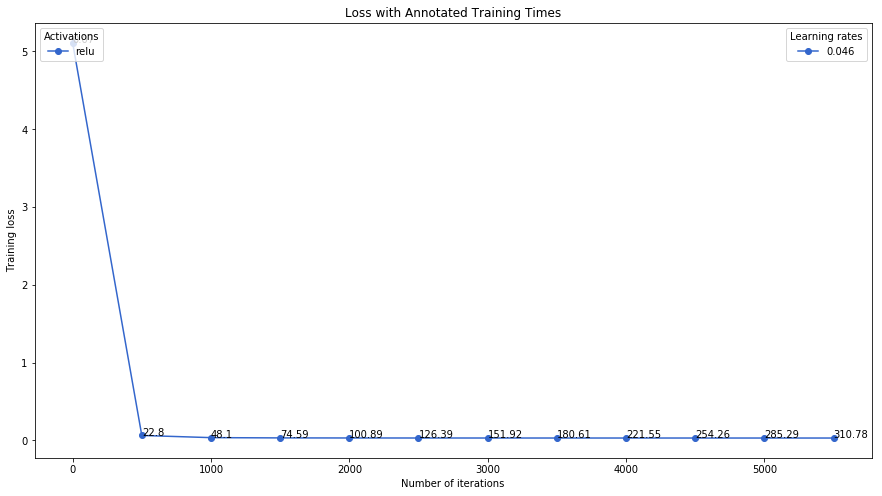

In [8]:
chart_colors = ['#3366CC', '#DC3912', '#FF9900', '#109618', '#990099',
                '#3B3EAC', '#0099C6', '#DD4477', '#66AA00']
chart_markers = ["o", "x", "s", ">", "D"]

# Organize `loss over # iterations` plot lines for learning rates
data = {a:
            {lr: 
                sorted(list(filter(lambda x: x['alpha'] == lr and x['activation'] == a, models)),
                        key=lambda x: x['iters'])
            for lr in learning_rates}
        for a in activations
}

# Create plot lines for learning rates and annotate with training times
lines = []
for i, (a, _) in enumerate(data.items()):
    seq = []
    for j, (lr, d) in enumerate(_.items()):
        evals = [x['train_loss'] for x in d]
        times = [x['time'] for x in d]
        seq.append(plt.plot(num_iters, evals, label=str(lr), color=chart_colors[j], marker=chart_markers[i])[0])
        for k, t in enumerate(times):
            plt.annotate(str(round(t, 2)), (num_iters[k], evals[k]))
    lines.append(seq)
   
# Format plot
legend1 = plt.legend(lines[0], learning_rates, loc=1, title='Learning rates')
plt.legend([l[0] for l in lines], [str(a).split()[1] for a in activations], loc=2, title='Activations')
plt.gca().add_artist(legend1)
plt.xlabel('Number of iterations')
plt.ylabel('Training loss')
plt.title('Loss with Annotated Training Times')

### Print the optimized accuracy for the test set. Plot train & test lost and train & test accuracy.

	# iterations | train accuracy | test accuracy
Activation: relu
	Learning rate: 0.046
			0  	  11.66 	  11.20
			500  	  99.91 	  93.27
			1000  	  100.00 	  93.53
			1500  	  100.00 	  93.60
			2000  	  100.00 	  93.80
			2500  	  100.00 	  93.93
			3000  	  100.00 	  94.00
			3500  	  100.00 	  94.13
			4000  	  100.00 	  94.20
			4500  	  100.00 	  94.20
			5000  	  100.00 	  94.20
			5500  	  100.00 	  94.20
The best model:
	Activation: relu
	Learning rate: 0.046
	# of iterations: 4000
	Training time: 221.54541111
	Training loss: 0.03176593
	Test loss: 0.51418899
	Training accuracy: 100.0
	Test accuracy: 94.2



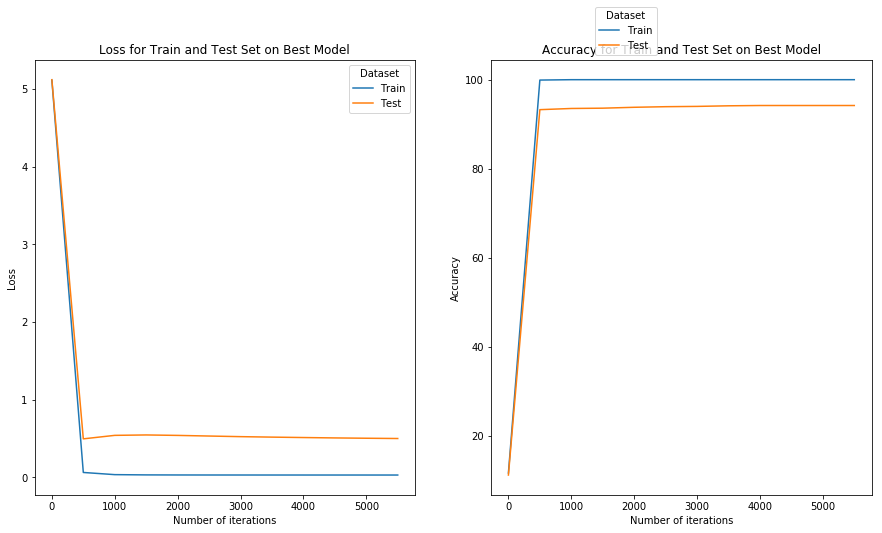

In [9]:
# Print the train and test accuracy for every combination of alpha and # of iterations
models_with_evals = []
print '\t# iterations | train accuracy | test accuracy'        
for a, _ in data.items():
    print 'Activation:', str(a).split()[1]
    for lr, dat in _.items():
        print '\tLearning rate:', lr
        for d in dat:
            train_score = eval_softmax(d['weights'], x_train, y_train, a)
            test_score = eval_softmax(d['weights'], x_test, y_test, a)
            models_with_evals.append((train_score, test_score, d, dat, a))
            print '\t\t\t{}  \t  {:.2f} \t  {:.2f}'.format(d['iters'], round(train_score, 2), round(test_score, 2))

# Print details about the model with the highest test accuracy
best = max(models_with_evals, key=lambda x: x[1])
print 'The best model:\n\tActivation: {}\n\tLearning rate: {}\n\t# of iterations: {}\n\tTraining time: {}\n\tTraining loss: {}\n\tTest loss: {}\n\tTraining accuracy: {}\n\tTest accuracy: {}\n'.format(
    str(best[-1]).split()[1], best[2]['alpha'], best[2]['iters'], *[round(b, 8) for b in [best[2]['time'], best[2]['train_loss'], best[2]['test_loss'], best[0], best[1]]]
) 

# Create plot data for train/test loss/accuracy of the best model
train_scores, train_losses, test_scores, test_losses = [], [], [], []
for d in best[-2]:
        train_scores.append(eval_softmax(d['weights'], x_train, y_train, best[-1]))
        test_scores.append(eval_softmax(d['weights'], x_test, y_test, best[-1]))
        train_losses.append(d['train_loss'])
        test_losses.append(d['test_loss'])

# Plot the train/test loss for the best model
plt.subplot(121)
lines = []
for d in [train_losses, test_losses]:
    lines.append(plt.plot(num_iters, d)[0])
plt.legend(lines, ['Train', 'Test'], title='Dataset')  
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.title('Loss for Train and Test Set on Best Model')

# Plot the train/test accuracy for the best model
plt.subplot(122)
lines = []
for d in [train_scores, test_scores]:
    lines.append(plt.plot(num_iters, d)[0])
plt.legend(lines, ['Train', 'Test'], title='Dataset', bbox_to_anchor=(0.26, 1))  
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy for Train and Test Set on Best Model')